In [621]:
import tensorflow
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import keras
from tensorflow import image
import tensorflow_addons as tfa
import os
from collections import Counter


In [731]:
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


tensorflow 2.3.1
numpy 1.18.1
PIL 8.0.1
tensorflow 2.3.1
tensorflow_datasets 4.1.0
keras 2.4.3
tensorflow_addons 0.11.2
pip 18.1


In [11]:
batch_size = 32
img_height = 128
img_width = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [691]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "train/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1481 files belonging to 3 classes.
Using 1185 files for training.


In [692]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "real_imgs/",
  #validation_split=1,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 402 files belonging to 3 classes.


In [547]:
class_names = train_ds.class_names
class_names

['cmfd', 'imfd', 'nomask']

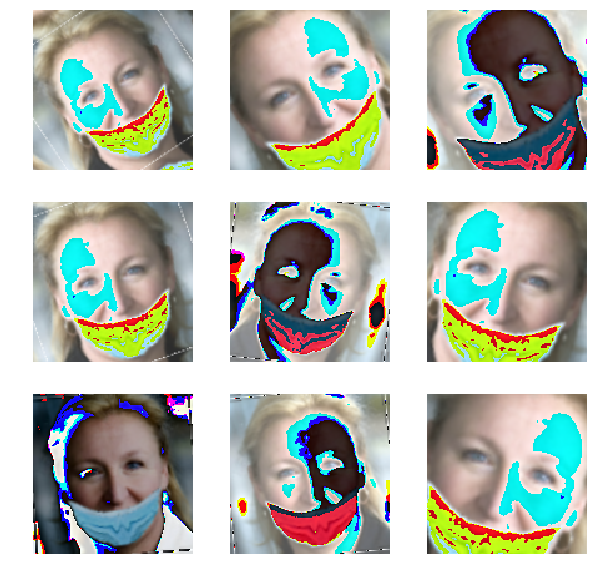

In [727]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[12].numpy().astype("uint8"))
        plt.axis("off")

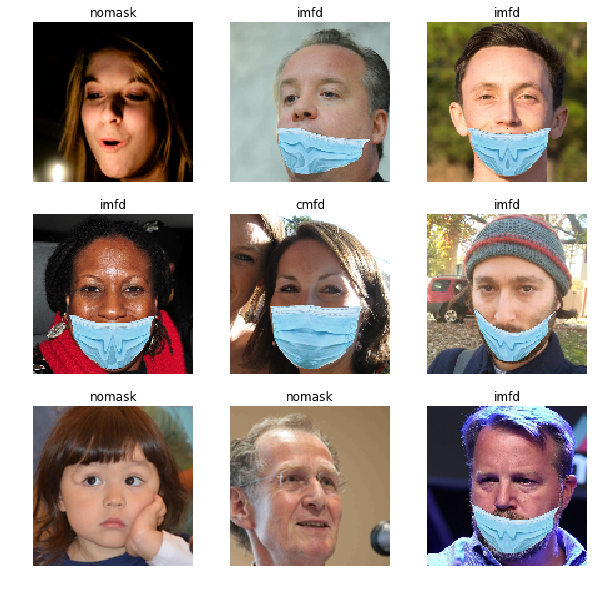

In [548]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

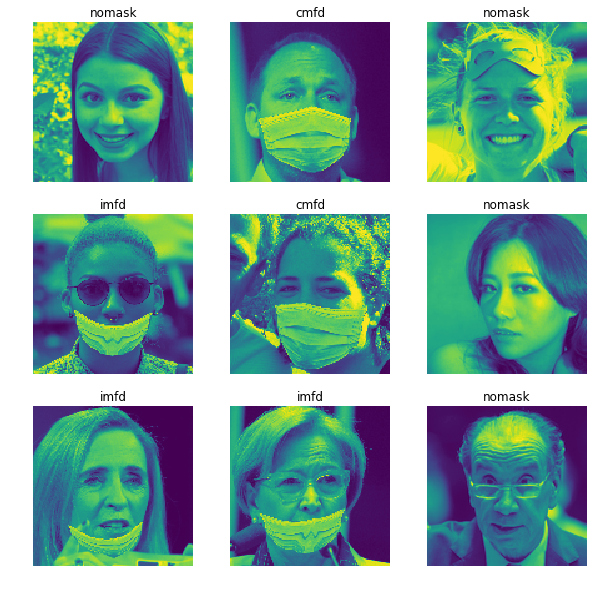

In [215]:
def to_grey_img(x):
    return image.rgb_to_grayscale(x)

def to_grey():
    return layers.Lambda(lambda x: to_grey_img(x))

to_grey = to_grey()

def grey_scale(ds):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (to_grey(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

#train_ds = grey_scale(train_ds)
#val_ds = grey_scale(val_ds)


In [693]:
#augment training data
def random_shift_img(x):
    if tf.random.uniform([])< 0.6:
        shift = tf.random.uniform([],minval=-250,maxval = 255)
        return x+shift
    else:
        return x
    

class RandomShift(layers.Layer):
    def __init__(self,dynamic = True, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return random_shift_img(x)


class Stretch(layers.Layer):
    def __init__(self,dynamic = True, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return tfa.image.transform(x, [0.5, 0, -250, 0.0, 1, 0.0, 0, 0.0])

    
    
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom((-0.5,0)),
    #to_grey
    RandomShift()
  ]
)
    

def prepare(ds):
    ds = ds.map(lambda x, y: (data_augmentation(x), y), 
                num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds.unbatch().batch(1)).unbatch().batch(batch_size)


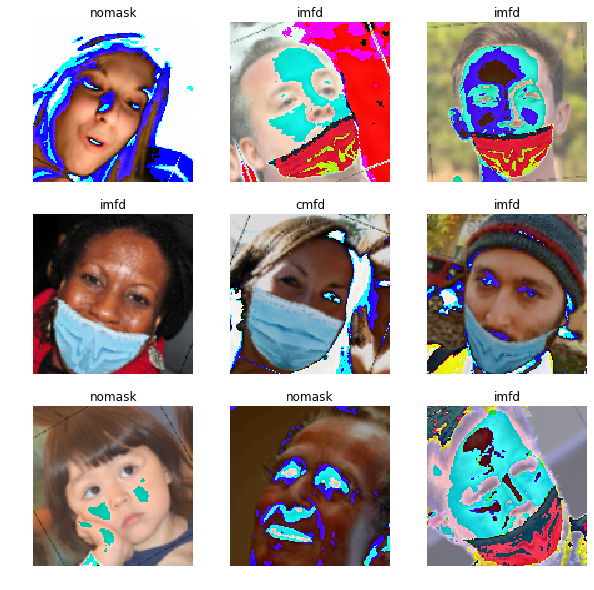

In [648]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [694]:

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [695]:
num_classes = 3


model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [696]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [697]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
38/38 [==============================] - 28s 730ms/step - loss: 0.6627 - accuracy: 0.7122 - val_loss: 1.1281 - val_accuracy: 0.6144
Epoch 2/10
38/38 [==============================] - 16s 434ms/step - loss: 0.1482 - accuracy: 0.9578 - val_loss: 1.6365 - val_accuracy: 0.5622
Epoch 3/10
38/38 [==============================] - 16s 417ms/step - loss: 0.0932 - accuracy: 0.9696 - val_loss: 1.4449 - val_accuracy: 0.6343
Epoch 4/10
38/38 [==============================] - 15s 408ms/step - loss: 0.0760 - accuracy: 0.9772 - val_loss: 1.3624 - val_accuracy: 0.6418
Epoch 5/10
38/38 [==============================] - 17s 435ms/step - loss: 0.0724 - accuracy: 0.9789 - val_loss: 1.6596 - val_accuracy: 0.6020
Epoch 6/10
38/38 [==============================] - 18s 482ms/step - loss: 0.0377 - accuracy: 0.9890 - val_loss: 2.5917 - val_accuracy: 0.5373
Epoch 7/10
38/38 [==============================] - 17s 455ms/step - loss: 0.0309 - accuracy: 0.9899 - val_loss: 1.9782 - val_accuracy: 0.6244

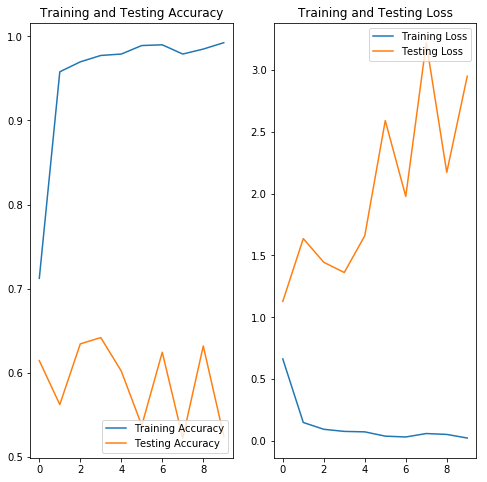

In [701]:
epochs = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

In [703]:
model.summary()

Model: "sequential_193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_64 (Rescaling)     (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_189 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_190 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_191 (MaxPoolin (None, 14, 14, 32)     

In [660]:
#test NN on real images
real_img_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "real_imgs/",
  batch_size = 1,
  seed=123,
  image_size=(img_height, img_width))

#real_img_ds = grey_scale(real_img_ds)

Found 402 files belonging to 3 classes.


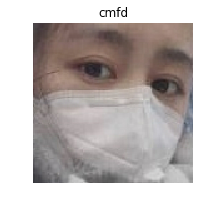

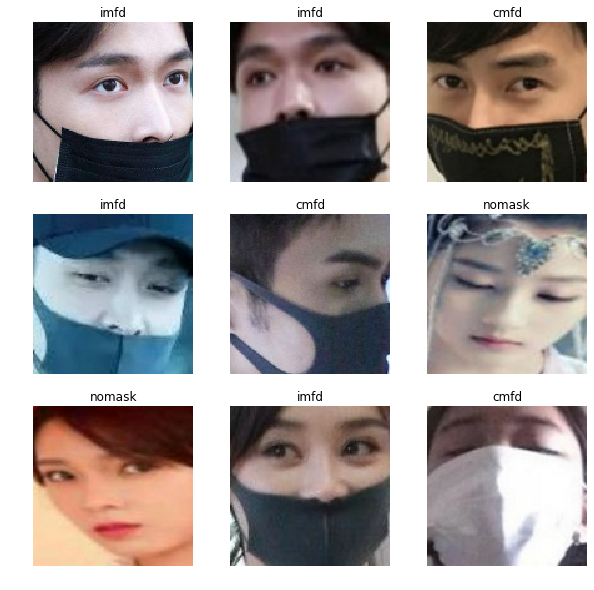

In [661]:
plt.figure(figsize=(10, 10))
for images, labels in real_img_ds.take(1):
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(images[i]).numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
plt.figure(figsize=(10, 10))
i=0
for images, labels in real_img_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(images[0]).numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")
    i+=1

In [662]:
results = model.evaluate(real_img_ds)


402/402 [==============================] - 7s 17ms/step - loss: 1.2741 - accuracy: 0.6642


In [610]:
img = keras.preprocessing.image.load_img(
    'real_imgs/cmfd/mask1.jpg', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

model.predict(img_array)[0].argmax()

2

In [664]:
directory1 = 'real_imgs/cmfd'
results1 = []
for filename in os.listdir(directory1):
    if filename.endswith(".jpg") :
        img = keras.preprocessing.image.load_img(os.path.join(directory1,filename), target_size=(img_height, img_width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        result = model.predict(img_array)
        idx  = result[0].argmax()
        results1.append(idx)
    else:
        continue
        
directory2 = 'real_imgs/imfd'
results2 = []
for filename in os.listdir(directory2):
    if filename.endswith(".jpg") :
        img = keras.preprocessing.image.load_img(os.path.join(directory2,filename), target_size=(img_height, img_width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        result = model.predict(img_array)
        idx  = result[0].argmax()
        results2.append(idx)
    else:
        continue

directory3 = 'real_imgs/nomask'
results3 = []
for filename in os.listdir(directory3):
    if filename.endswith(".jpg") :
        img = keras.preprocessing.image.load_img(os.path.join(directory3,filename), target_size=(img_height, img_width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        result = model.predict(img_array)
        idx  = result[0].argmax()
        results3.append(idx)
    else:
        continue

Text(0, 0.5, 'Accuracy')

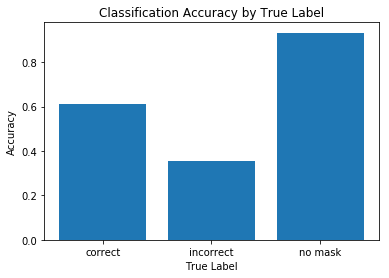

In [685]:
correct_classification_percent = [Counter(results1)[0]/len(results1),Counter(results2)[1]/len(results2),Counter(results3)[2]/len(results3)]
plt.bar(['correct','incorrect','no mask'],correct_classification_percent)
plt.title("Classification Accuracy by True Label")
plt.xlabel('True Label')
plt.ylabel('Accuracy')

<BarContainer object of 3 artists>

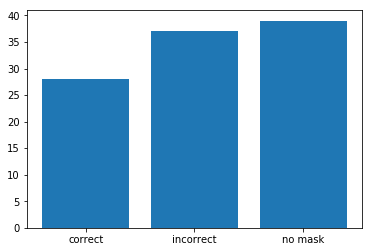

In [686]:
Counter(results2)
imfd_predictions = [Counter(results2)[0],Counter(results2)[1],Counter(results2)[2]]
plt.bar(['correct','incorrect','no mask'],imfd_predictions)

<BarContainer object of 3 artists>

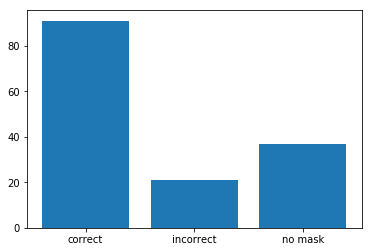

In [687]:

cmfd_predictions = [Counter(results1)[0],Counter(results1)[1],Counter(results1)[2]]
plt.bar(['correct','incorrect','no mask'],cmfd_predictions)

In [58]:
#logistic regression
# MNIST dataset parameters.

num_classes = 2 

num_features = 50*50*3

# Training parameters.

learning_rate = 0.01

training_steps = 1000

batch_size_lr = 16

display_step = 50


In [59]:
W = tf.Variable(tf.ones((num_features,num_classes)), name="weight")
b = tf.Variable(tf.zeros([num_classes]), name="bias")


In [60]:
train_ds_lr = tf.keras.preprocessing.image_dataset_from_directory(
  "imgs/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

val_ds_lr = tf.keras.preprocessing.image_dataset_from_directory(
  "imgs/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=350)

class_names = train_ds_lr.class_names


Found 1944 files belonging to 2 classes.
Using 1556 files for training.
Found 1944 files belonging to 2 classes.
Using 388 files for validation.


In [61]:
#normalize images
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5,offset=-1)
train_ds_lr = train_ds_lr.map(lambda x, y: (normalization_layer(x), y))

train_ds_lr = train_ds_lr.unbatch()
train_data = train_ds_lr.repeat(training_steps).shuffle(50).batch(batch_size_lr).prefetch(1)
train_data

<PrefetchDataset shapes: ((None, 50, 50, 3), (None,)), types: (tf.float32, tf.int32)>

In [62]:
# Logistic regression (Wx + b).

def logistic_regression(x):

    # Apply softmax to normalize the logits to a probability distribution.

    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function.

def cross_entropy(y_pred, y_true):

    # Encode label to a one hot vector.

    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Compute cross-entropy.

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

In [63]:
# Accuracy metric.

def accuracy(y_pred, y_true):

# Predicted class is the index of the highest score in prediction vector (i.e. argmax).

    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Stochastic gradient descent optimizer.

optimizer = tf.optimizers.SGD(learning_rate)

In [64]:
# Optimization process. 

def run_optimization(x, y):

# Wrap computation inside a GradientTape for automatic differentiation.

    with tf.GradientTape() as g:

        pred = logistic_regression(x)

        loss = cross_entropy(pred, y)

    # Compute gradients.

    gradients = g.gradient(loss, [W, b])

  

    # Update W and b following gradients.

    optimizer.apply_gradients(zip(gradients, [W, b]))

In [65]:
# Run training for the given number of steps.

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):

    # Run the optimization to update W and b values.
    run_optimization(tf.reshape(batch_x, (batch_size_lr,num_features)), batch_y)    

    if step % display_step == 0:

        pred = logistic_regression(tf.reshape(batch_x, (batch_size_lr,num_features)))

        loss = cross_entropy(pred, batch_y)

        acc = accuracy(pred, batch_y)

        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 50, loss: 47.949272, accuracy: 0.812500
step: 100, loss: -0.000000, accuracy: 1.000000
step: 150, loss: 0.000180, accuracy: 1.000000
step: 200, loss: 20.723267, accuracy: 0.937500
step: 250, loss: -0.000000, accuracy: 1.000000
step: 300, loss: -0.000000, accuracy: 1.000000
step: 350, loss: 0.000001, accuracy: 1.000000
step: 400, loss: -0.000000, accuracy: 1.000000
step: 450, loss: 0.000000, accuracy: 1.000000
step: 500, loss: -0.000000, accuracy: 1.000000
step: 550, loss: 0.000282, accuracy: 1.000000
step: 600, loss: 0.000064, accuracy: 1.000000
step: 650, loss: 0.000002, accuracy: 1.000000
step: 700, loss: -0.000000, accuracy: 1.000000
step: 750, loss: 0.000000, accuracy: 1.000000
step: 800, loss: 0.000175, accuracy: 1.000000
step: 850, loss: -0.000000, accuracy: 1.000000
step: 900, loss: 0.000001, accuracy: 1.000000
step: 950, loss: 0.000001, accuracy: 1.000000
step: 1000, loss: 9.713927, accuracy: 0.937500


In [67]:
#normalize images
val_ds_lr = val_ds_lr.map(lambda x, y: (normalization_layer(x), y))

# Test model on train set.
for images,labels in val_ds_lr.take(1):
    pred = logistic_regression(tf.reshape(images, (350, num_features)))

    print("Test Accuracy: %f" % accuracy(pred, labels))

Test Accuracy: 0.962857
